# import
对于本章，我们将需要以下导入：

In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, \
precision_recall_curve, auc

from stepbystep.v0 import StepByStep

ModuleNotFoundError: No module named 'stepbystep'

# 分类问题
我们现在将切换到处理称为分类问题的不同类别的问题。在分类问题中，我们试图预测数据点属于哪个类别。假设我们有两类点；它们要么是红色要么是蓝色。这些是点的标签 ( y )。果然，我们需要给它们赋数值。我们可以将 0 分配给红色，将 1 分配给蓝色。与零相关联的类是负类，而一对应于正类。简而言之，对于二进制分类，我们有：

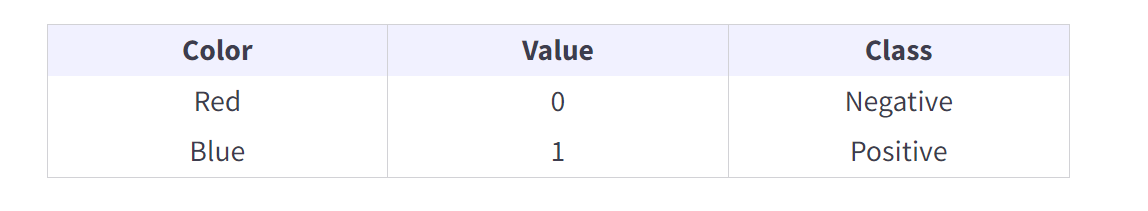

在分类模型中，输出是正类的预测概率。在我们的例子中，模型将预测一个点为蓝色的概率。选择哪个类别是正面的，哪个类别是负面的，不会影响模型性能。如果我们反转映射，使红色成为正类，唯一的区别将是模型会预测一个点为红色的概率。但是，由于两个概率之和必须为 1，我们可以轻松地在它们之间进行转换，因此模型是等价的。我们不是先定义模型然后为它生成合成数据，而是反过来做。

## 数据生成
这次让我们使用两个特征（x 1 和 x 2 ）使数据更有趣。我们将使用 Scikit-Learn 的 1 方法生成一个包含 100 个数据点的玩具数据集。我们还将添加一些高斯噪声，并设置随机种子以确保再现性。

In [1]:
from sklearn.datasets import make_moons

# using make_moons to generate 100 data points dataset
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
print(X.shape, y.shape)

(100, 2) (100,)


然后，为方便起见，我们将使用 Scikit-Learn 的 train_test_split 方法执行训练验证拆分。稍后我们将回到拆分索引：

In [3]:
# Performing train-validation split using train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=.2, 
    random_state=13
)
# Displaying the values of the training and validation sets (first five only)
print("Training:{} \n\nValidation:{}".format(X_train[:5], X_val[:5]))
# 以上代码使用了train_test_split函数，将原始数据集（X和y）分成训练集（X_train和y_train）和验证集（X_val和y_val）两部分。
# 其中，test_size=.2指定了验证集占原始数据集的20%；random_state=13是指定了一个随机数种子，以确保每次分割数据集的结果
# 都是相同的。
# 最后，代码打印出了训练集和验证集的前五个值，分别对应X_train和X_val。

Training:[[-0.0551441  -0.03733246]
 [ 0.82954503 -0.53932149]
 [ 1.66760217 -0.42485665]
 [-0.88230758  0.07249044]
 [-0.59702417  0.6572361 ]] 

Validation:[[ 0.18121142  0.24717743]
 [ 0.20718083 -0.09767143]
 [-0.87539365  0.50543423]
 [ 0.46730819  0.54703192]
 [-1.06964997  0.13666025]]


接下来，我们将使用 Scikit-Learn 的 StandardScaler 对特征进行标准化

In [4]:
# Standardizing the features using StandardScaler
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

# Displaying the values of the training and validation sets after standardizing (first five only)
print("Training:{} \n\nValidation:{}".format(X_train[:5], X_val[:5]))
# 以上代码使用了StandardScaler函数来对原始数据集进行标准化处理，以确保不同特征之间的数值范围相同。
# 首先，使用fit函数对X_train进行了拟合，计算出每个特征的均值和标准差。然后，使用transform函数将X_train和X_val分别标准化，
# 使得它们的均值为0，方差为1。这里是对X_train和X_val进行相同的变换，以确保它们具有相同的比例和分布，避免模型对训练
# 和验证数据的处理方式不同而导致的偏差。

Training:[[-0.59635346 -0.51713419]
 [ 0.3937561  -1.35813138]
 [ 1.33167696 -1.16636502]
 [-1.52208256 -0.33314461]
 [-1.20280449  0.64649722]] 

Validation:[[-0.33183358 -0.04048629]
 [-0.30276963 -0.61822186]
 [-1.51434476  0.39217903]
 [-0.01164524  0.46186888]
 [-1.73174885 -0.22563902]]


请记住，您应该只使用训练集来拟合 StandardScaler ，然后使用它的 transform 方法将预处理步骤应用于所有数据集：训练、验证和测试。否则，您会将验证和/或测试集中的信息泄露给您的模型！

下图显示了生成的训练和验证数据

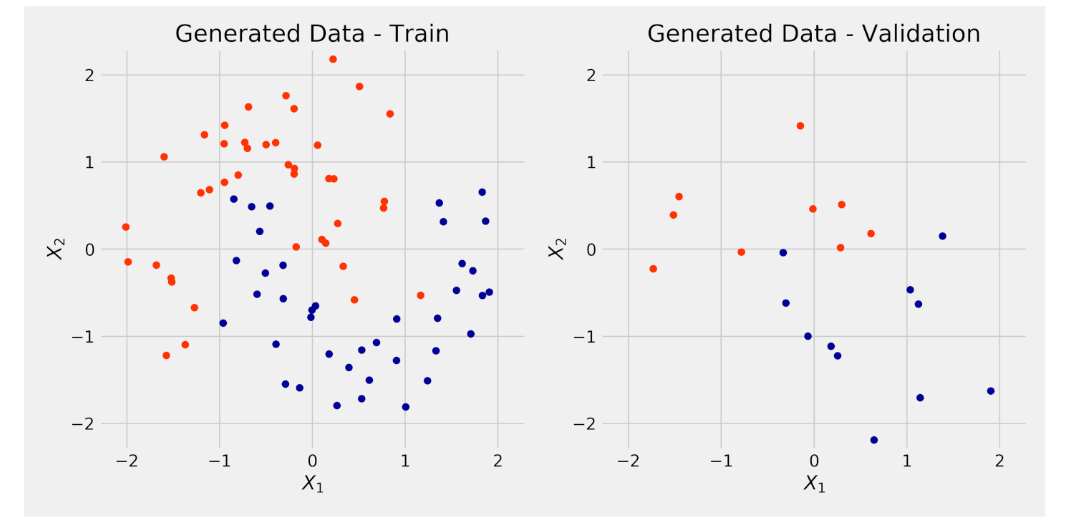

## 数据准备
希望您已经熟悉此步骤。像往常一样，数据准备步骤将 Numpy 数组转换为 PyTorch 张量，为它们构建 TensorDatasets，并创建相应的数据加载器。

In [5]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()#-1的意思是自动计算行数，1的意思是列数为1

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)
# Displaying the corresponding training and validation dataloaders
print("{} \n\n{}".format(train_loader, val_loader))

我们的训练集中有 80 个数据点 ( N = 80 )。我们有 x 1 和 x 2 两个特征，标签 ( y ) 为零（红色）或一（蓝色）。我们有一个数据集，现在我们需要创建我们的模型。

# 分类问题模型
## Model
给定分类问题，最直接的模型之一是逻辑回归。但是，我们不是简单地展示它并立即使用它，而是要建立它。这种方法背后的基本原理是双重的。首先，它会阐明如果将此算法用于分类，为什么称为逻辑回归。其次，你会对什么是logit有一个清晰的认识。
## 线性回归 
好吧，既然它被称为“逻辑回归”，那么线性回归是我们构建它的一个很好的起点。具有两个特征的线性回归模型会是什么样子？

$\begin{aligned}y=b+w_1x_1+w_2x_2+\epsilon\end{aligned}$

上面的模型有一个明显的问题。我们的标签 ( y ) 是离散的，这意味着它们只能是零或一。我们需要稍微更改模型以使其适应我们的目的。

有道理，对吧？无论如何，我们已经称它们为正类和负类。为什么不好好利用他们的名字呢？我们的模型看起来像这样：

$ \begin{aligned}y=\left\{\begin{array}{cc}1,&\textit{if }b+w_1x_1+w_2x_2\geq0\\ 0,&\textit{if }b+w_1x_1+w_2x_2<0\end{array}\right.\end{aligned}$

下面是一个例子：

In [6]:
import numpy as np

# Variables initialized
b = -1
w1, w2 = 2, 3
N = 5

# Computing linear regression
np.random.seed(42)
x1 = x2 = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = b + (w1 * x1) + (w2 * x2) + epsilon

# Mapping linear regression model to labels
results = [1 if num >= 0 else 0 for num in y]

# Displaying the results
print("Values of y:")
print(y)
print("\nLabels:")
print(results)

Values of y:
[[ 0.90060472]
 [ 3.85462306]
 [ 2.6018819 ]
 [ 1.94077544]
 [-0.27704481]]

Labels:
[1, 1, 1, 1, 0]


## Logits
为了让我们的更轻松，让我们给上面等式的右边起一个名字：logit (z)。

$z=b+w_1x_1+w_2x_2$

上面的等式与原始线性回归模型惊人地相似，但我们将结果值称为“z”或“logit”，而不是 y 或“label”。下面是一个例子：

In [7]:
import numpy as np

# Variables initialized
b = -1
w1, w2 = 2, 3
N = 5

# Computing logits
np.random.seed(42)
x1 = x2 = np.random.rand(N, 1)
z = b + (w1 * x1) + (w2 * x2)

# Displaying the results
print("Values of z:")
print(z)

Values of z:
[[ 0.87270059]
 [ 3.75357153]
 [ 2.65996971]
 [ 1.99329242]
 [-0.2199068 ]]


“这是否意味着 logit 与线性回归相同？”不完全的。它们之间有一个根本区别；上面的 logit 方程中没有误差项 (epsilon)。
## 概率
如果数据点的 logit 等于零，则它恰好位于决策边界，因为它既不是正数也不是负数。为了完整起见，我们将其分配给正类，但这种分配具有最大的不确定性。因此，相应的概率需要为 0.5 (50%)，因为它可以任意选择。按照这种推理，我们希望将较大的正 logit 值分配给较高的概率（属于正类），将较大的负 logit 值分配给较低的概率（属于正类）。对于非常大的正负 logit 值 (z)，我们希望：

$ \begin{aligned}P(y=1)\approx1.0,ifz=>0\\ \\ P(y=1)=0.5,ifz=0\\ \\ P(y=1)\approx0.0,ifz<<0\end{aligned}$

我们仍然需要找出一个将 logit 值映射到概率的函数。我们很快就会到达那里。但首先，我们需要谈谈“比值比”。

优势比由成功概率 ( p ) 和失败概率 ( q ) 之间的比率给出:

$\quad oddsratio(p)=\dfrac{p}{q}=\dfrac{p}{1-p}$

在代码中，我们的 odds_ratio 函数如下所示：

In [19]:
def odds_ratio(prob):
    return prob / (1 - prob)

p = .75
q = 1 - p
print(odds_ratio(p), odds_ratio(q))

3.0 0.3333333333333333


## 对数比率
通过取比值比的对数，该函数不仅是对称的，而且还将概率映射为实数，而不仅仅是正数：

$ \begin{aligned}logoddsratio(p)=log(\dfrac{p}{1-p})\end{aligned} $

在代码中，我们的 log_odds_ratio 函数如下所示：

In [18]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
print(log_odds_ratio(p), log_odds_ratio(q))

1.0986122886681098 -1.0986122886681098


正如预期的那样，加起来为 100% 的概率（如 75% 和 25%）对应于绝对值相同的对数优势比。让我们绘制它：

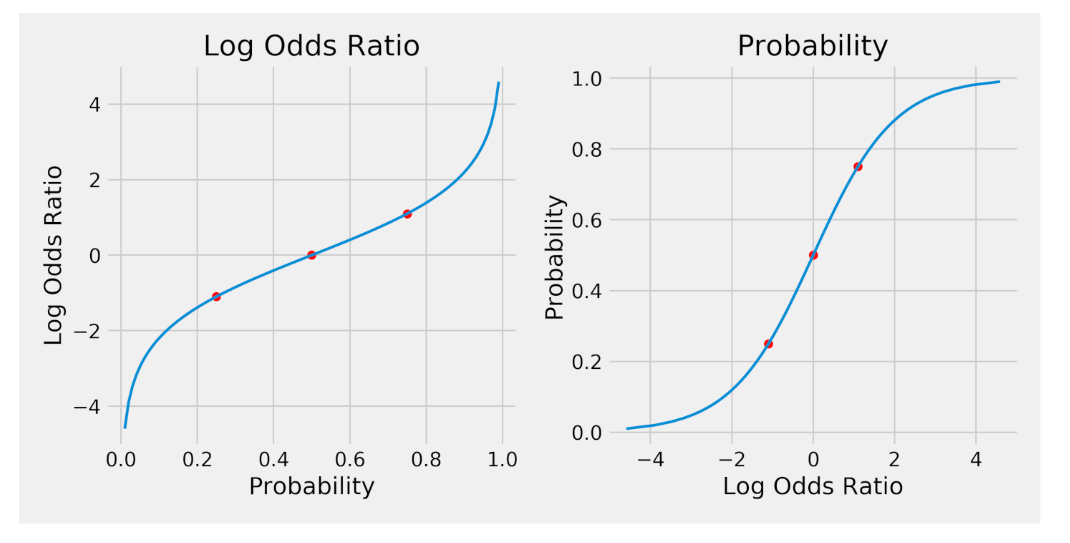

在左侧，每个概率映射到对数比值比。红点分别对应25%、50%、75%的概率，和之前一样。如果我们翻转水平轴和垂直轴（右图），我们正在反转函数，从而将每个对数比值比映射为概率。这正是我们正在寻找的功能！

# Sigmoid和逻辑回归
了解 sigmoid 如何在将 logit 值映射到概率中发挥联系及其在逻辑回归中的作用。我们正在尝试将 logit 值映射到概率中，并且我们以图形方式找到了将对数优势比映射到概率中的函数。显然，我们的对数是对数比值比。当然，得出这样的结论并不十分科学，但本练习的目的是说明回归结果（以对数 (z) 表示）如何映射到概率。所以，这就是我们到达的地方：

$ \begin{array}{rcl}b+w_1x_1+w_2x_2=z&=log(\dfrac{p}{1-p})\\\\ e^{b+w_1x_1+w_2x_2}=e^z=\dfrac{p}{1-p}\end{array}$

让我们稍微计算一下这个等式，反转、重新排列和简化一些项以分离$p$：

$\begin{aligned}&\frac{1}{e^z}=\frac{1-p}{p}\\\\ &e^{-z}=\frac{1}{p}-1\\\\ &1+e^{-z}=\frac{1}{p}\\\\ &p=\frac{1}{1+e^{-z}}\end{aligned}$

是不是很眼熟？那是一个 sigmoid 函数！它是对数比值比的倒数，具有以下等式：

$p=\sigma\big(z\big)=\dfrac{1}{1+e^{-z}}$

下面也给出了这方面的代码：

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
print(sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q)))

NameError: name 'log_odds_ratio' is not defined

## Sigmoid
不过没有必要实现我们自己的 sigmoid 函数。 PyTorch 提供了两种不同的方式来使用 sigmoid：**torch.sigmoid 和 nn.Sigmoid** 。第一个是一个简单的函数，就像上面的那个。但相反，它需要一个张量作为输入并返回另一个张量：

In [9]:
import torch

print(torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986)))

tensor(0.7500) tensor(0.2500)


第二个是从 nn.Module 继承的完整类。就所有意图和目的而言，它本身就是一个模型。然而，它是一个非常简单明了的模型，因为它只实现了一个 forward 方法，该方法调用了 torch.sigmoid 。
## Sigmoid、非线性和激活函数 
sigmoid 函数是非线性的。它可用于将 logits 映射到概率，正如我们刚刚发现的那样。但这不是它的唯一目的！非线性函数在神经网络中起着基础性作用。我们通过通常的名称了解这些非线性：激活函数。sigmoid 是“受生物学启发”的，是过去使用的第一个激活函数。紧随其后的是双曲正切 (TanH)，最近又出现了整流线性单元 (ReLU) 及其衍生的一整套函数。

逻辑回归是一种模型，其中（给定 $x_1$和 $x_2$
的两个特征，模型将拟合线性回归，使其输出为 $logits (z)$，使用 sigmoid 函数将其转换为概率。这将有以下等式：

$ P(y=1)=\sigma(z)=\sigma(b+w_1x_1+w_2x_2)$

一图胜千言，让我们想象一下：

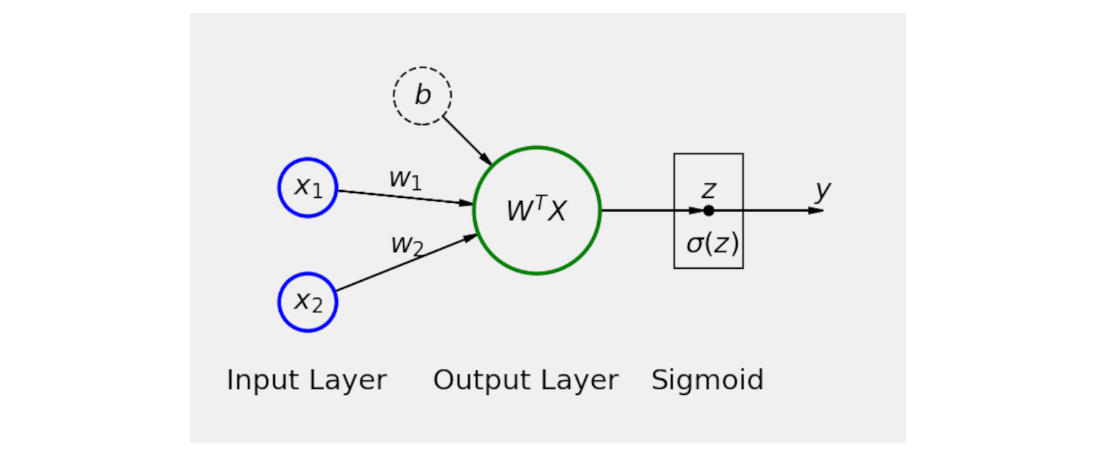

我们可以将逻辑回归视为第二简单的神经网络。它与线性回归几乎相同，但对输出层 (z) 的结果应用了 sigmoid。现在记住这一点，让我们使用 Sequential 模型在 PyTorch 中构建我们的逻辑回归：

In [10]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


您是否注意到 state_dict 仅包含来自 linear 层的参数？尽管该模型有第二个 sigmoid 层，但该层不包含任何参数，因为它不需要学习任何东西。无论它属于哪个模型，sigmoid 函数都是相同的。

## 关于符号的注释
到目前为止，我们已经处理了一个特征或两个特征。它使我们能够拼出方程式，列出所有术语。但是如果我们开始处理像图像这样的输入，特征的数量很容易增加。所以我们需要就矢量化特征的符号达成一致。实际上，如果你观察上面给出的逻辑回归图，你可以清楚地看到我们已经在那里使用它了。$logits (z)$ 由以下表达式给出：

$z=W^T\cdot X~=~[-~w^T-]~\cdot~\begin{bmatrix}1\\ x_1\\ x_2\\ x_2\\ \end{bmatrix}~=~[b~w_1~w_2]~\cdot\begin{bmatrix}1\\ x_1\\ x_2\\ x_2\\ \end{bmatrix} =b+w_1x_1+w_2x_2 $

# 损失
## 定义适当的损失 
我们已经有了一个模型，现在我们需要为它定义一个合适的损失。二元分类问题需要二元交叉熵 (BCE) 损失，有时称为对数损失。
BCE 损失需要预测概率（由 sigmoid 函数返回）和用于计算的真实标签 ( y )。对于训练集中的每个数据点 i ，它首先计算与该点的真实类别对应的误差。如果数据点属于正类 ( y=1 )，我们希望我们的模型预测的概率接近于 1，对吗？一个完美的结果是 1 的对数，即 0。这说得通;完美的预测意味着零损失。它是这样的：

$\begin{aligned}y_i=1=>error_i=log\big(P(y_i=1)\big)\end{aligned}$

如果数据点属于负类（ y=0 ）怎么办？那么，我们不能简单地使用预测概率。为什么不？因为模型输出的是一个点属于正类而不是负类的概率。幸运的是，后者可以很容易地计算出来：

$ \begin{aligned}P(y_i=0)=1-P(y_i=1)\end{aligned}$

因此，与属于负类的数据点相关的错误如下所示:

$\begin{aligned}y_i=0=>error_i=log\big(1-P\big(y_i=1\big)\big)\end{aligned}$

一旦所有的错误都被计算出来，它们就会被聚合成一个损失值。

## 二元交叉熵损失(BCE)
对于二元交叉熵损失，我们简单地取误差的平均值并反转其符号。这将有以下等式：

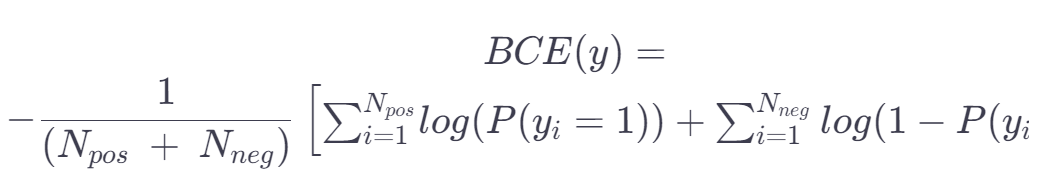

假设我们有两个虚拟数据点，每个类别一个。然后，让我们假设我们的模型为它们做出了预测：0.9 和 0.2。预测还不错，因为它预测实际阳性为阳性的概率为 90%，实际阴性为阳性的概率仅为 20%。这在代码中看起来像什么？这里是：

In [11]:
import torch

dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
print(loss)

tensor(0.1643)


第一个求和将与正类中的点对应的误差相加。第二次求和将与负类中的点对应的误差相加。上面的公式非常简单易懂。不幸的是，它通常被跳过，只提供它的等价物：

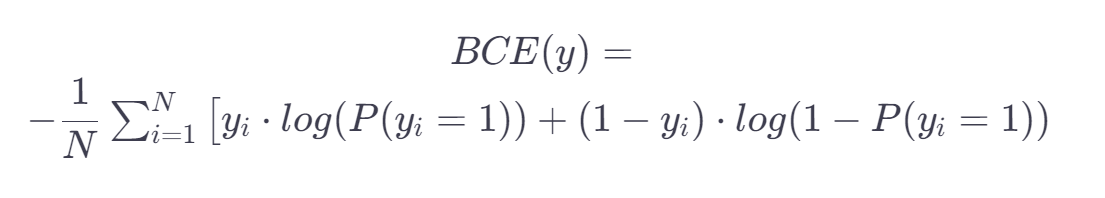

上面的公式是在单个表达式中计算损失的一种巧妙方法，但正负点的分裂不太明显。如果暂停一分钟，您会发现正类 ( y=1 ) 中的点的第二项等于零，而负类 ( y=0 ) 中的点的第一项等于零。让我们看看它在代码中的样子：

In [12]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
print(loss)

tensor(0.1643)


# PyTorch 中的二元交叉熵损失

果然，PyTorch 实现了二进制交叉熵损失，[ nn.BCELoss ]。就像它的回归对应物 MSELoss （在简单回归问题一章中介绍）一样，它是一个返回实际损失函数的高阶函数。BCELoss 高阶函数有两个可选参数（其他参数已弃用，您可以安全地忽略它们）：
- reduction ：它需要 mean 、 sum 或 none 。默认的 mean 对应于我们在上一课中的等式 6.15。正如预期的那样， sum 将返回误差总和而不是平均值。最后一个选项 none 对应于未简化的形式；也就是说，它返回完整的错误数组。
- weight ：默认为 none 。也就是说，每个数据点都具有相同的权重。如果通知，它需要是一个张量，其大小等于小批量中的元素数量，表示分配给批量中每个元素的权重。换句话说，此参数允许您根据其位置为当前批次的每个元素分配不同的权重。因此，第一个元素将具有给定的权重，第二个元素将具有不同的权重，依此类推。这与该特定数据点的实际类别无关。听起来很混乱？诡异的？是的，这很奇怪。当然，这并非无用或错误，但该参数的正确使用是一个更高级的主题，超出了本课程的范围。


In [13]:
import torch.nn as nn

loss_fn = nn.BCELoss(reduction='mean')
print(loss_fn)

BCELoss()


正如预期的那样， BCELoss 返回了另一个函数：实际的损失函数。后者同时采用预测和标签来计算损失。确保首**先将预测传递给损失函数，然后将标签传递给损失函数**。顺序在这个损失函数的实现中很重要，但它与均方误差的重要性不同。

In [14]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


显然，顺序很重要。这很重要，因为 BCELoss 取概率的对数，这是预期的第一个参数。如果我们交换参数，它会产生不同的结果。到目前为止，一切都很好。但是还有另一种二元交叉熵损失可用，知道何时使用其中一种非常重要，这样您就不会以模型和损失函数的不一致组合而告终。此外，您将理解我们为什么对 logits 如此大惊小怪。

##  BCEWithLogitsLoss
前一个损失函数将概率作为参数（显然连同标签）。此损失函数将 logits 作为参数而不是概率。您必须使用正确的模型和损失函数组合。
- 方案一： nn.Sigmoid 作为最后一层。意思是，您的模型正在产生概率，并结合 nn.BCELoss 函数。
- 方案二：最后一层没有sigmoid；意思是，您的模型正在生成 logits，结合 nn.BCEWithLogitsLoss 函数。混合 nn.Sigmoid 和 nn.BCEWithLogitsLoss 是错误的。

此外，选项 2 是首选，因为它在数值上比选项 1 更稳定。

现在参数的区别已经很清楚了，让我们仔细看看 nn.BCEWithLogitsLoss 函数。它也是一个高阶函数，但它需要三个可选参数。其他的已弃用，您可以安全地忽略它们：
- reduction ：它需要 mean 、 sum 或 none ，并且它的工作方式与 nn.BCELoss 中的一样。默认值为 mean 。
- weight ：这个参数也和 nn.BCELoss 一样有效，不太可能被使用。
- pos_weight ：正样本的权重；它必须是一个张量，其长度等于与数据点关联的标签数量（文档指的是类而不是标签，这只会让一切变得更加混乱）

我们处理的是单标签二元分类（每个数据点只有一个标签），标签是二元的。如果标签为零，我们说它属于负类。如果标签是one，则属于正类。请不要将我们单标签的正类和负类与文档中所谓的类号c混淆。 c 对应于与数据点关联的不同标签的数量。在我们的示例中，c = 1。

足够的谈话（或写作！）。让我们看看如何在代码中使用这种损失。我们首先创建损失函数本身：

In [15]:
import torch.nn as nn

loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')
print(loss_fn_logits)

BCEWithLogitsLoss()


接下来，我们使用 logits 和 labels 来计算损失。按照和之前一样的原则，应该是先logits，再labels。为了保持示例的一致性，让我们使用 log_odds_ratio 函数获取对应于我们之前使用的概率的 logits 值：0.9 和 0.2：

In [20]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


我们有 logits 和标签。计算损失：

In [21]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
print(loss)

tensor(0.1643)


# 不平衡数据集
在我们有两个数据点的虚拟示例中，我们有每个类别之一：正面和负面。数据集是完美平衡的。让我们创建另一个具有不平衡的虚拟示例，添加两个属于负类的额外数据点。为了简单起见并说明 BCEWithLogitsLoss 行为中的一个怪癖，我们将为这两个额外点赋予与负类中其他数据点相同的 logits。它看起来像这样：

In [22]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

print(dummy_imb_labels, dummy_imb_logits)

tensor([1., 0., 0., 0.]) tensor([ 2.1972, -1.3863, -1.3863, -1.3863], dtype=torch.float64)


显然，这是一个不平衡的数据集。负类中的数据点是正类中的三倍。
## pos_weight 参数
现在，让我们转向 BCEWithLogitsLoss 的 pos_weight 参数。为了补偿这种不平衡，可以将权重设置为负例与正例的比率：.

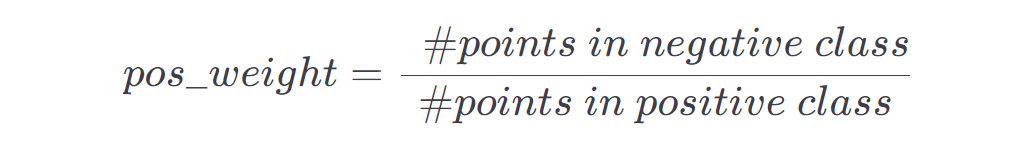

在我们的不平衡虚拟示例中，结果将是 3.0。这样，正类中的每个点都会将其相应的损失乘以三。由于每个数据点 (c = 1) 都有一个标签，因此用作 pos_weight 参数的张量只有一个元素： tensor([3.0]) 。我们可以这样计算：


In [23]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
print(pos_weight)

tensor([3.])


现在，让我们创建另一个损失函数，这次包括 pos_weight 参数：

In [24]:
loss_fn_imb = nn.BCEWithLogitsLoss(
	reduction='mean', 
	pos_weight=pos_weight
)

然后，我们可以使用这个加权损失函数来计算不平衡数据集的损失。我想人们会期待和以前一样的损失；毕竟，这是一个加权损失。正确的？

In [25]:
loss_fn_imb = nn.BCEWithLogitsLoss(
	reduction='mean', 
	pos_weight=pos_weight
)

loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
print(loss)

tensor(0.2464)


错误的！当我们有两个数据点时，它是 0.1643，每个类一个。现在它是 0.2464，即使我们为正类分配了权重。“为什么不一样？”下面给你解答
# 加权平均
好吧，事实证明，PyTorch 不计算加权平均值。这就是您对加权平均值的期望：

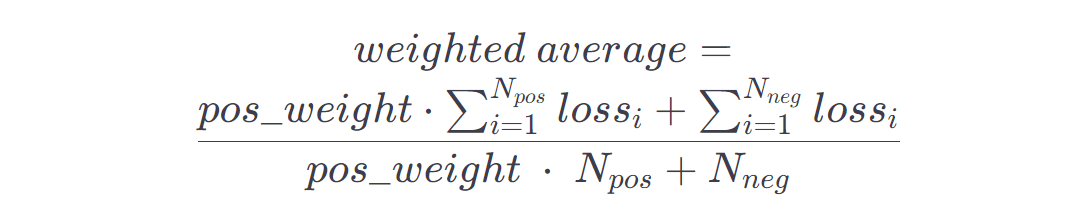

这就是 PyTorch 所做的：

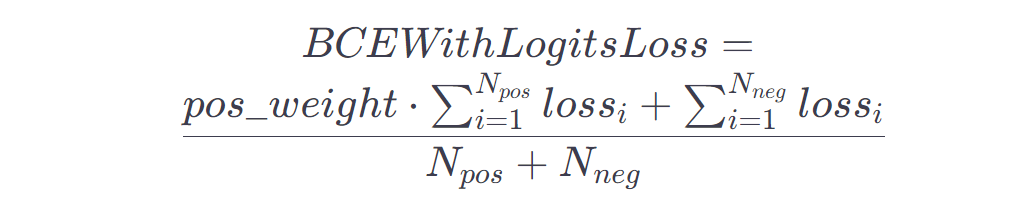

看到分母的差异了吗？当然，如果你乘以正例的损失而不乘以它们的数量 (N)，你最终会得到一个比实际加权平均值更大的数字。

“如果我真的想要加权平均值怎么办？”这并不难。还记得 reduction 参数吗？如果我们将它设置为 sum ，我们的损失函数将只返回上面等式的分子。然后我们可以自己除以加权计数。

In [26]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(
	reduction='sum', 
	pos_weight=pos_weight
)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)
loss = loss / (pos_weight * n_pos + n_neg)

print(loss)

tensor([0.1643])


# 分类的模型配置、训练和预测
## 模型配置
在“Going Classy”一章中，我们以精益模型配置部分结束。我们只需要定义一个模型、一个合适的损失函数和一个优化器。让我们定义一个生成 logits 并使用 BCEWithLogitsLoss 作为损失函数的模型。由于我们有两个特征，并且我们生成的是对数而不是概率，因此我们的模型只有一层和一层： Linear(2, 1) 。我们现在将继续使用学习率为 0.1 的 SGD 优化器。这是我们的分类问题的模型配置：

In [27]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE with logits loss function
loss_fn = nn.BCEWithLogitsLoss()

## 模型训练 
是时候训练我们的模型了！我们可以利用我们在 Going Classy 一章中构建的 StepByStep 类，并使用与之前几乎相同的代码：
```python
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)
```


In [29]:
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

    def _make_train_step(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step
    
    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

In [30]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

检查模型的训练参数了：

In [31]:
# Checking model parameters
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]], device='cuda:0')), ('linear.bias', tensor([-0.0591], device='cuda:0'))])


我们的模型产生了 logits，对吗？所以我们可以将上面的权重代入相应的 logit 方程（方程 6.3），我们最终得到：

$\begin{aligned}z=b+w_1x_1+w_2x_2\\ \\ z=-0.0587+1.1822x_1-1.8684x_2\end{aligned}$

上面的值 z 是我们模型的输出。这是一个“美化的线性回归”。这是一个分类问题！怎么会？保持那个想法；在下一课中会变得更加清楚。

## 做出预测 
但是，在走这条路之前，让我们使用我们的模型（和 StepByStep 类）对训练集中的前四个数据点进行预测：

In [32]:
predictions = sbs.predict(x_train_tensor[:4])
print(predictions)

[[ 0.20345592]
 [ 2.9444451 ]
 [ 3.6933177 ]
 [-1.2334073 ]]


显然，这些不是概率，对吧？这些是预期的逻辑。我们仍然可以得到相应的概率。“我们如何从逻辑到概率？”这就是 sigmoid 函数的好处。
代码如下所示：

In [33]:
probabilities = sigmoid(predictions)
print(probabilities)

[[0.5506892 ]
 [0.9500003 ]
 [0.9757152 ]
 [0.22558564]]


根据我们的模型，这些是这四个点是正例的概率。最后，我们需要从概率到类别。如果概率大于或等于一个阈值，则为正例。如果小于阈值，则为反例。很简单。阈值的简单选择是 0.5：

$y=\left\{\begin{array}{cc}1,&ifP(y=1)\geq0.5\\ 0,&ifP(y=1)<0.5\end{array}\right.$

但概率本身只是应用于 logit (z) 的 sigmoid 函数：

$y=\left\{\begin{array}{ccc}1,&if&\sigma(z)\geq0.5\\ 0,&if&\sigma(z)<0.5\end{array}\right.$

但只有当 logit (z) 的值为零时，sigmoid 函数的值为 0.5：

$y=\left\{\begin{array}{ccc}1,&\textit{if }z\geq0\\ 0,&\textit{if }z<0\end{array}\right.$ 

因此，如果我们不关心概率，我们可以直接使用预测（logits）来获得数据点的预测类别：


In [34]:
classes = (predictions >= 0).astype(int)
print(classes)

[[1]
 [1]
 [1]
 [0]]


显然，logits (z) 等于零的点决定了正例和负例之间的边界。

# 决策边界
逻辑回归的决策边界，我们刚刚发现，只要 z 等于零，我们就处于决策边界。但是 z 是由特征 x 1 和 x 2 的线性组合给出的。如果我们计算出一些基本操作，我们会得出：

$\begin{array}{rcl}z&=&0&=&b&+&w_1x_1+&w_2x_2\\\\ &-w_2x_2&=&b&+&w_1x_1\\\\ &x_2&=&-\dfrac{b}{w_2}-\dfrac{w_1}{w_2}x_1\\\\ \end{array}$

给定我们的模型（b、w 1 和 w 2 ），对于第一个特征 (x 1 ) 的任意值，我们可以计算第二个特征 (x 2 ) 的对应值恰好在决策边界。

让我们在其中插入我们训练模型的权重：

$\begin{matrix}x_2&=&-\dfrac{0.0587}{1.8684}&+&\dfrac{1.1822}{1.8684}x_1\\ \\ x_2&=&-0.0314&+&0.6327x_1\end{matrix}$

一图胜千言

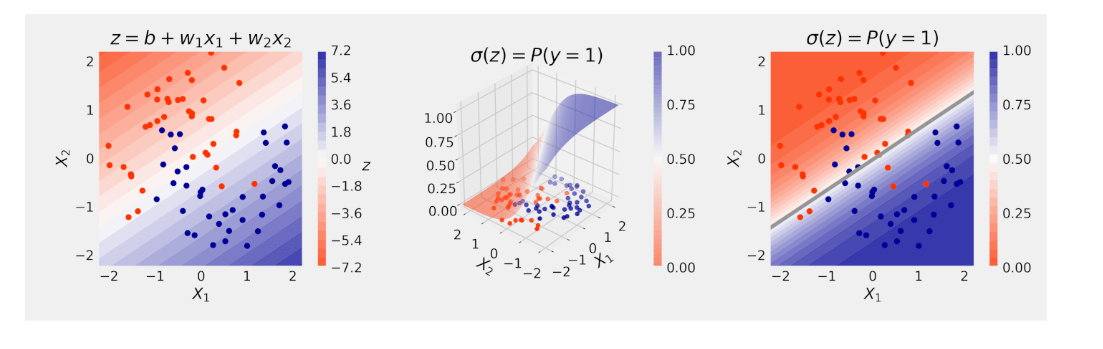

上图说明了整个故事。它仅包含训练集中的数据点。因此，这就是模型在训练时“看到”的内容。它将尝试实现两个类之间的最佳分离，描绘为红色（负类）和蓝色（正类）点。

在左图中，我们有一个 logits (z) 的等高线图（还记得本章中损失曲面的那些，可视化梯度下降吗？）。在中心图中，我们有一个 3D 图，显示了将 sigmoid 函数应用于 logits 所产生的概率。您甚至可以在 3D 中看到 sigmoid 函数的形状向左接近 0，向右接近 1。

最后，在右图中，我们有概率的等高线图，因此它与中心图相同，但没有炫酷的 3D 效果。也许它不那么酷，但肯定更容易理解正在发生的事情。较深的蓝色（红色）颜色表示较高（较低）的概率，我们将决策边界作为一条灰色直线对应于 50% 的概率（和零对数值）。

我们的模型生成了一条直线，可以很好地分离红点和蓝点，对吧？好吧，这并不难，因为蓝点更多地集中在右下角，而红点主要集中在左上角。换句话说，类是完全可分离的。

## 验证数据集决策边界
现在我们可以理解验证损失低于训练损失。在验证集中，类比在训练集中更可分离。使用训练集获得的决策边界可以更好地分离红点和蓝点。让我们检查一下，根据与上面相同的等高线图绘制验证集：

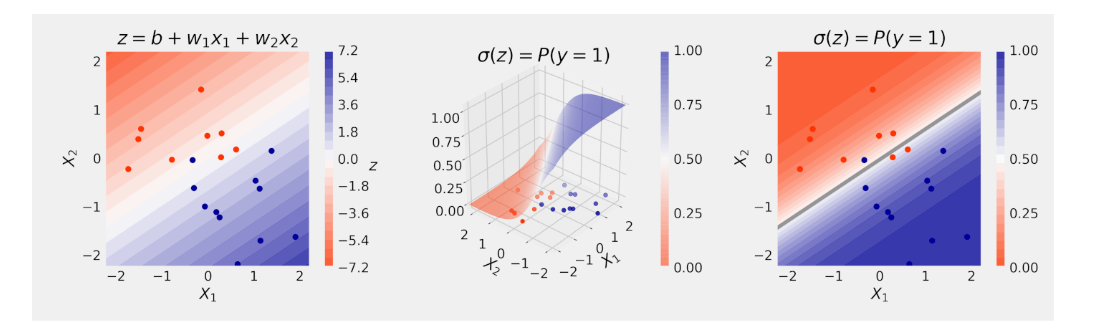

看？除了真正接近决策边界的三个点（两个红色和一个蓝色）之外，数据点被正确分类。确实更可分离。
## 我的数据点是可分离的吗？ 

在上面的例子中，我们可以清楚地看到验证集中的数据点比训练集中的数据点更可分离。如果这些点根本不可分离，会发生什么？让我们快速绕道而行，看看另一个包含 10 个数据点（7 个红色和 3 个蓝色）的小型数据集。颜色是标签 (y)，每个数据点都有一个特征 (x 1 )。我们可以沿着一条线绘制它们；毕竟，我们只有一个维度。你能用一条直线把蓝点和红点分开吗？很明显不是。这些点是不可分离的（即在一维中）。

如果它在一维中不起作用，请尝试使用两个！不过只有一个问题。另一个维度从何而来？不过，我们可以在这里使用一个技巧；我们将函数应用于原始维度（特征），并将结果用作第二个维度（特征）。很简单，对吧？

对于手头的小数据集，我们可以尝试 square 函数：

$\begin{aligned}X_2=f(X_1)={X_1}^2\end{aligned}$

现在看起来怎么样？

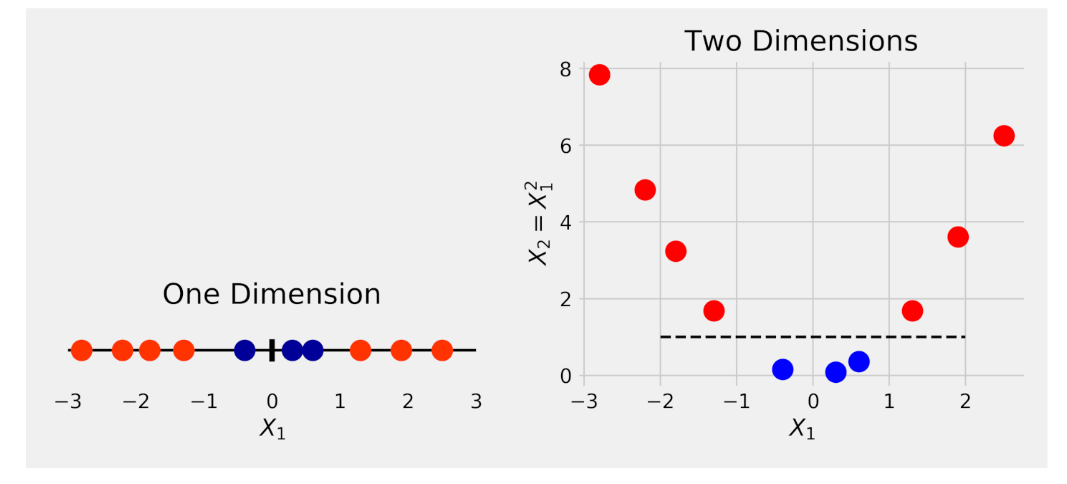

## 增加维度的影响 
回到最初的问题：“你能用一条直线把蓝点和红点分开吗？”在二维中，这是小菜一碟！解释这个技巧为何有效超出了本课程的范围。重要的是要理解这里的总体思路；随着维数的增加，空白空间越来越多。如果数据点相距较远，则可能更容易将它们分开。在二维中，决策边界是一条线。在三个维度上，它是一个平面。在四个或更多维度中，它是一个超平面（对于您无法绘制的平面的更漂亮的措辞）。

您听说过支持向量机 (SVM) 的内核技巧吗？这几乎就是它的作用！内核就是我们用来创建额外维度的函数。我们使用的平方函数是一个多项式，所以我们使用了一个多项式内核。

下面是一个例子：

In [35]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())
 
loss_fn = nn.BCELoss()
print(model)

Sequential(
  (hidden): Linear(in_features=2, out_features=10, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


上面的模型将维度从两个维度（两个特征）增加到十个维度，然后使用这十个维度来计算 logits。但它只有在层与层之间存在激活函数时才有效。